In [3]:
import sys
sys.path.insert(0, '/users/ankushroy/iris/src')
print(sys.path)

['/users/ankushroy/iris/src', '/users/ankushroy/iris/src/models', '/users/ankushroy/anaconda3/envs/myenv_exp_1/lib/python38.zip', '/users/ankushroy/anaconda3/envs/myenv_exp_1/lib/python3.8', '/users/ankushroy/anaconda3/envs/myenv_exp_1/lib/python3.8/lib-dynload', '', '/users/ankushroy/anaconda3/envs/myenv_exp_1/lib/python3.8/site-packages']


In [4]:
from typing import Any, Optional, Tuple

from einops import rearrange
import torch
import torch.nn as nn
import torch.nn.functional as F

import hydra
from hydra.utils import instantiate
from omegaconf import DictConfig, OmegaConf
import torch
import tqdm
import torch.nn as nn
from tqdm import tqdm

from dataset import Batch
from models.kv_caching import KeysValues
from models.slicer import Embedder, Head
from models.tokenizer import Tokenizer
from models.transformer import Transformer, TransformerConfig
from utils import init_weights, LossWithIntermediateLosses

In [3]:
# Define dataset
import torch
import sys

import h5py
from PIL import Image
#import matplotlib.pyplot as plt
from datetime import datetime, timedelta
def eventGeneration(start_time, obs_time = 3 ,lead_time = 6, time_interval = 30):
    # Generate event based on starting time point, return a list: [[t-4,...,t-1,t], [t+1,...,t+72]]
    # Get the start year, month, day, hour, minute
    year = int(start_time[0:4])
    month = int(start_time[4:6])
    day = int(start_time[6:8])
    hour = int(start_time[8:10])
    minute = int(start_time[10:12])
    #print(datetime(year=year, month=month, day=day, hour=hour, minute=minute))
    times = [(datetime(year, month, day, hour, minute) + timedelta(minutes=time_interval * (x+1))) for x in range(lead_time)]
    lead = [dt.strftime('%Y%m%d%H%M') for dt in times]
    times = [(datetime(year, month, day, hour, minute) - timedelta(minutes=time_interval * x)) for x in range(obs_time)]
    obs = [dt.strftime('%Y%m%d%H%M') for dt in times]
    obs.reverse()
    return lead, obs

from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
from torchvision.transforms import ToTensor, Compose, CenterCrop
class radarDataset(Dataset):
    def __init__(self, root_dir, event_times, obs_number = 3, pred_number = 6, transform=None):
        # event_times is an array of starting time t(string)
        # transform is the preprocessing functions
        self.root_dir = root_dir
        self.transform = transform
        self.event_times = event_times
        self.obs_number = obs_number
        self.pred_number = pred_number
    def __len__(self):
        return len(self.event_times)
    def __getitem__(self, idx):
        start_time = str(self.event_times[idx])
        time_list_pre, time_list_obs = eventGeneration(start_time, self.obs_number, self.pred_number)
        output = []
        time_list = time_list_obs + time_list_pre
        #print(time_list)
        for time in time_list:
            year = time[0:4]
            month = time[4:6]
            #path = self.root_dir + year + '/' + month + '/' + 'RAD_NL25_RAC_MFBS_EM_5min_' + time + '_NL.h5'
            path = self.root_dir + year + '/' + month + '/' + 'RAD_NL25_RAP_5min_' + time + '.h5'
            image = np.array(h5py.File(path)['image1']['image_data'])
            #image = np.ma.masked_where(image == 65535, image)
            image = image[264:520,242:498]
            image[image == 65535] = 0
            image = image.astype('float32')
            image = image/100*12
            image = np.clip(image, 0, 128)
            image = image/40
            #image = 2*image-1 #normalize to [-1,1]
            output.append(image)
        output = torch.permute(torch.tensor(np.array(output)), (1, 2, 0))
        output = self.transform(np.array(output))
        return output, start_time
#root_dir = '/users/hbi/data/RAD_NL25_RAC_MFBS_EM_5min/'
#dataset = radarDataset(root_dir, ["200808031600"], transform = Compose([ToTensor(),CenterCrop(256)]))

In [4]:
# develop dataset
from torch.cuda.amp import autocast
#from torch.autograd import Variable
import pandas as pd
root_dir = '/home/hbi/RAD_NL25_RAP_5min/' 

df_train = pd.read_csv('/users/hbi/taming-transformers/training_Delfland08-14_20.csv', header = None)
event_times = df_train[0].to_list()
mfbs = df_train[1].to_list()
dic_mfbs1 = dict(zip(event_times, mfbs))
dataset_train = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))  

df_train_s = pd.read_csv('/users/hbi/taming-transformers/training_Delfland08-14.csv', header = None)
event_times = df_train_s[0].to_list()
mfbs = df_train_s[1].to_list()
dic_mfbs2 = dict(zip(event_times, mfbs))
dataset_train_del = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))  

df_test = pd.read_csv('/users/hbi/taming-transformers/testing_Delfland18-20.csv', header = None)
event_times = df_test[0].to_list()
mfbs = df_test[1].to_list()
dic_mfbs4 = dict(zip(event_times, mfbs))
dataset_test = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))

df_vali = pd.read_csv('/users/hbi/taming-transformers/validation_Delfland15-17.csv', header = None)
event_times = df_vali[0].to_list()
mfbs = df_vali[1].to_list()
dic_mfbs5 = dict(zip(event_times, mfbs))
dataset_vali = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))

df_train_aa = pd.read_csv('/users/hbi/taming-transformers/training_Aa08-14.csv', header = None)
event_times = df_train_aa[0].to_list()
mfbs = df_train_aa[1].to_list()
dic_mfbs6 = dict(zip(event_times, mfbs))
dataset_train_aa = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))  

df_train_dw = pd.read_csv('/users/hbi/taming-transformers/training_Dwar08-14.csv', header = None)
event_times = df_train_dw[0].to_list()
mfbs = df_train_dw[1].to_list()
dic_mfbs7 = dict(zip(event_times, mfbs))
dataset_train_dw = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))    

df_train_re = pd.read_csv('/users/hbi/taming-transformers/training_Regge08-14.csv', header = None)
event_times = df_train_re[0].to_list()
mfbs = df_train_re[1].to_list()
dic_mfbs8 = dict(zip(event_times, mfbs))
dataset_train_re = radarDataset(root_dir, event_times, transform = Compose([ToTensor()]))   

data_list = [dataset_train_aa, dataset_train_dw, dataset_train_del, dataset_train_re]
train_aadedwre = torch.utils.data.ConcatDataset(data_list)

dic_mfbs = {}
dic_mfbs.update(dic_mfbs1)
dic_mfbs.update(dic_mfbs2)
dic_mfbs.update(dic_mfbs4)
dic_mfbs.update(dic_mfbs5)
dic_mfbs.update(dic_mfbs6)
dic_mfbs.update(dic_mfbs7)
dic_mfbs.update(dic_mfbs8)
new_valid = ['202008161600']
new_valid.sort()
        
dataset_ext = radarDataset(root_dir, new_valid, transform = Compose([ToTensor()])) 

print(len(dataset_train), len(dataset_test), len(dataset_vali))
loaders = { 'train' :DataLoader(train_aadedwre, batch_size=1, shuffle=True, num_workers=8),
            'test' :DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=8), 
           'valid' :DataLoader(dataset_vali, batch_size=1, shuffle=False, num_workers=8),
          'ext' :DataLoader(dataset_ext, batch_size=1, shuffle=False, num_workers=8),
          'train_aa5' :DataLoader(dataset_train_aa, batch_size=1, shuffle=False, num_workers=8),
          'train_dw5' :DataLoader(dataset_train_dw, batch_size=1, shuffle=False, num_workers=8),
          'train_del5' :DataLoader(dataset_train_del, batch_size=1, shuffle=True, num_workers=8),
          'train_re5' :DataLoader(dataset_train_re, batch_size=1, shuffle=False, num_workers=8),
          }

32183 3493 3560


In [5]:
from utils import configure_optimizer, EpisodeDirManager, set_seed
import hydra
from omegaconf import OmegaConf
config =OmegaConf.load('/users/junzheyin/iris/config/trainer.yaml')
cfg=config
# Access the configuration and perform further operations
# For example, print the contents of the configuration
print(config)


if config.common.seed is not None:
        set_seed(config.common.seed)

print(set_seed)


@hydra.main(config_path='/users/junzheyin/iris/config/', config_name='trainer.yaml')
def config_function(cfg):
    # Access the configuration
    config_file = OmegaConf.load(cfg)
  
    return config_file


cfg_worldmodel = config_function('/users/junzheyin/iris/config/world_model/default.yaml')
cfg_tokenizer = config_function('/users/junzheyin/iris/config/tokenizer/default.yaml')

{'defaults': ['_self_', {'tokenizer': 'default'}, {'world_model': 'default'}, {'actor_critic': 'default'}, {'env': 'default'}, {'datasets': 'default'}], 'wandb': {'mode': 'disabled', 'project': 'iris', 'entity': None, 'name': None, 'group': None, 'tags': None, 'notes': None}, 'initialization': {'path_to_checkpoint': None, 'load_tokenizer': False, 'load_world_model': False, 'load_actor_critic': False}, 'common': {'epochs': 600, 'device': 'cuda:0', 'do_checkpoint': True, 'seed': 0, 'sequence_length': '${world_model.max_blocks}', 'resume': False}, 'collection': {'train': {'num_envs': 1, 'stop_after_epochs': 500, 'num_episodes_to_save': 10, 'config': {'epsilon': 0.01, 'should_sample': True, 'temperature': 1.0, 'num_steps': 200, 'burn_in': '${training.actor_critic.burn_in}'}}, 'test': {'num_envs': 8, 'num_episodes_to_save': '${collection.train.num_episodes_to_save}', 'config': {'epsilon': 0.0, 'should_sample': True, 'temperature': 0.5, 'num_episodes': 16, 'burn_in': '${training.actor_critic

In [6]:
device = torch.device(cfg.common.device)
print(device)

cuda:0


In [7]:
from utils import configure_optimizer, EpisodeDirManager, set_seed
from models.world_model import WorldModel
tokenizer = instantiate(cfg_tokenizer)

world_model = WorldModel(obs_vocab_size=tokenizer.vocab_size,config=instantiate(cfg_worldmodel))
world_model.to(device)
tokenizer.to(device)
print(tokenizer.vocab_size)
optimizer_trans = configure_optimizer(world_model, cfg.training.learning_rate, cfg.training.world_model.weight_decay)

Tokenizer : shape of latent is (256, 16, 16).
768
1024


In [8]:
checkpoint = torch.load('/space/junzheyin/tokenizer_70', map_location=device)
# print(checkpoint.keys())
tokenizer.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [9]:
checkpoint1 = torch.load('/space/junzheyin/transformer_checkpoint/transformer_140', map_location=device)
print(checkpoint.keys())
world_model.load_state_dict(checkpoint1['model_state_dict'])

dict_keys(['model_state_dict', 'optimizer_state_dict'])


<All keys matched successfully>

In [10]:
def top_k_logits(logits, k):
    v, ix = torch.topk(logits, k)
    out = logits.clone()
    out[out < v[:, [-1]]] = -float('Inf')
    return out

@torch.no_grad()
def sample(model, x, steps, temperature=1.0, sample=False, top_k=None):
    """
    take a conditioning sequence of indices in x (of shape (b,t)) and predict the next token in
    the sequence, feeding the predictions back into the model each time. Clearly the sampling
    has quadratic complexity unlike an RNN that is only linear, and has a finite context window
    of block_size, unlike an RNN that has an infinite context window.
    """
    block_size = model.get_block_size()
    model.eval()
    for k in range(steps):
        x_cond = x if x.size(1) <= block_size else x[:, -block_size:]  # crop context if needed
        logits, _ = model(x_cond)
        # pluck the logits at the final step and scale by temperature
        logits = logits[:, -1, :] / temperature
        # optionally crop probabilities to only the top k options
        if top_k is not None:
            logits = top_k_logits(logits, top_k)
        # apply softmax to convert to probabilities
        probs = F.softmax(logits, dim=-1)
        # sample from the distribution or take the most likely
        if sample:
            ix = torch.multinomial(probs, num_samples=1)
        else:
            _, ix = torch.topk(probs, k=1, dim=-1)
        # append to the sequence and continue
        x = torch.cat((x, ix), dim=1)

    return x

In [11]:
# import os
# class LatentDataset(Dataset):
#     def __init__(self, root_dir, radarset):
#         # event_times is an array of starting time t(string)
#         # transform is the preprocessing functions
#         self.root_dir = root_dir
#         self.radarset = radarset
#     def __len__(self):
#         if self.radarset: return len(self.radarset)
#         else: return 30000
#     def __getitem__(self, idx):
#         dir_file = self.root_dir + str(idx) + '.pt'
#         if os.path.exists(dir_file):
#             tokens = torch.load(dir_file, map_location='cpu')
#             return tokens
#         else:
#             print("File not found")
#             return None

# latent_valid = LatentDataset('/space/junzheyin/vali1517iris/validset', dataset_vali)
# latent_test = LatentDataset('/space/junzheyin/test1820iris/testset', dataset_test)
# latent_train_de5  = LatentDataset('/space/junzheyin/train0814_Delf_iris/trainset', dataset_train_del)
# latent_train_aa5  = LatentDataset('/space/junzheyin/train0814_Aa_iris/trainset', dataset_train_aa)
# latent_train_dw5  = LatentDataset('/space/junzheyin/train0814_Dwar_iris/trainset', dataset_train_dw)
# latent_train_re5 = LatentDataset('/space/junzheyin/train0814_Regge_iris/trainset', dataset_train_re)
# latent_list = [latent_train_de5, latent_train_aa5, latent_train_dw5, latent_train_re5]
# latent_train_aadedwre = torch.utils.data.ConcatDataset(latent_list)

# loaders_latent = { 'test' :DataLoader(latent_test, batch_size=1, shuffle=True, num_workers=0),
#                   'train_aadedwre' :DataLoader(latent_train_aadedwre, batch_size=1, shuffle=True, num_workers=0)}
# print(len(loaders_latent['train_aadedwre']))

In [12]:
# torch.cuda.empty_cache()


# import time
# import matplotlib.pyplot as plt 
# from pysteps.verification.detcatscores import det_cat_fct
# from pysteps.verification.detcontscores import det_cont_fct
# from pysteps.verification.spatialscores import intensity_scale
# from pysteps.visualization import plot_precip_field
# from einops import rearrange, repeat

# pcc_average = 0
# pcc_average1 = 0
# pcc_average2 = 0

# # Assuming loaders_latent and tokens are already initialized
# for i, latent in enumerate(loaders_latent['test']):
#     #tokens_tensor = latent[0] 
#     tokens_tensor = latent[0]

#     if i < 0:
#         continue
#     if i >= 1:
#         break
#     # Move the tokens to the device
#     tokens_tensor1 = tokens_tensor.to(device).squeeze(0)

#     predict= world_model.forward(tokens_tensor)
    
#     predicted_obs=predict[1]
#     print(predicted_obs.size())
#     print("Predicted observations", predicted_obs.size())
#     predicted_obs=predicted_obs.view(-1,1024)

#     #predicted_obs = top_k_logits(predicted_obs, 10)
#     #print("Predictd", predicted_obs.size())

#     tokens = torch.multinomial(torch.softmax(predicted_obs, dim=-1), num_samples=1)
#     tokens=tokens.squeeze(-1)
#     print("generated", tokens.size())
    
#     predicted_tokens= rearrange(tokenizer.embedding(tokens), '(b h w) e -> b e h w', b=6, e=256, h=16, w=16).contiguous()
#     print(predicted_tokens.size())
#     predict_1=tokenizer.decode(predicted_tokens[:,:,:,:])
#     print("Predicted1", predict_1.size())
#     #predict_1=predict_1[0:1,:,:,:]
#     #print("Predicted1", predict_1.size())


#     z_q=tokenizer.embedding(tokens_tensor1)
#     # Rearrange the tensor using Einops
#     z_q = rearrange(z_q, '(b h w) e -> b e h w', b=9, e=256, h=16, w=16).contiguous()
    
#     # Decode using tokenizer
#     reco = tokenizer.decode(z_q)
#     print(reco.size())
#     for t in range(6):
#         a_r_display = reco[t,0,:,:].to('cpu').detach().numpy()*40
#         a_r1_display = predict_1[t,0,:,:].to('cpu').detach().numpy()*40
#         print(a_r_display.shape)
#         plt.figure(figsize=(16, 4))

#         plt.subplot(132)
#         plot_precip_field(a_r_display, title="Reconstruction")
#         plt.subplot(133)
#         plot_precip_field(a_r1_display, title="Prediction")    
            
            
#         plt.tight_layout()
#         plt.show()

Pysteps configuration file found at: /users/junzheyin/anaconda3/envs/iris/lib/python3.8/site-packages/pysteps/pystepsrc

201805291515
images_size torch.Size([1, 9, 256, 256])
input image torch.Size([1, 9, 1, 256, 256])
torch.Size([1, 9, 256])
torch.Size([1, 3, 256])
torch.Size([9, 1, 256, 256])
tensor([[407,  49,  86,  ..., 625, 293, 808]], device='cuda:0')
2304
Predicted observations torch.Size([1, 1536, 1024])
Predictd1 torch.Size([1536, 1024])
Predictd2 torch.Size([1536, 1024])
generated torch.Size([1536])
torch.Size([6, 256, 16, 16])
Predicted1 torch.Size([6, 1, 256, 256])
3
0
3
Start Time: 201805291515 Lead Time: 30 mins


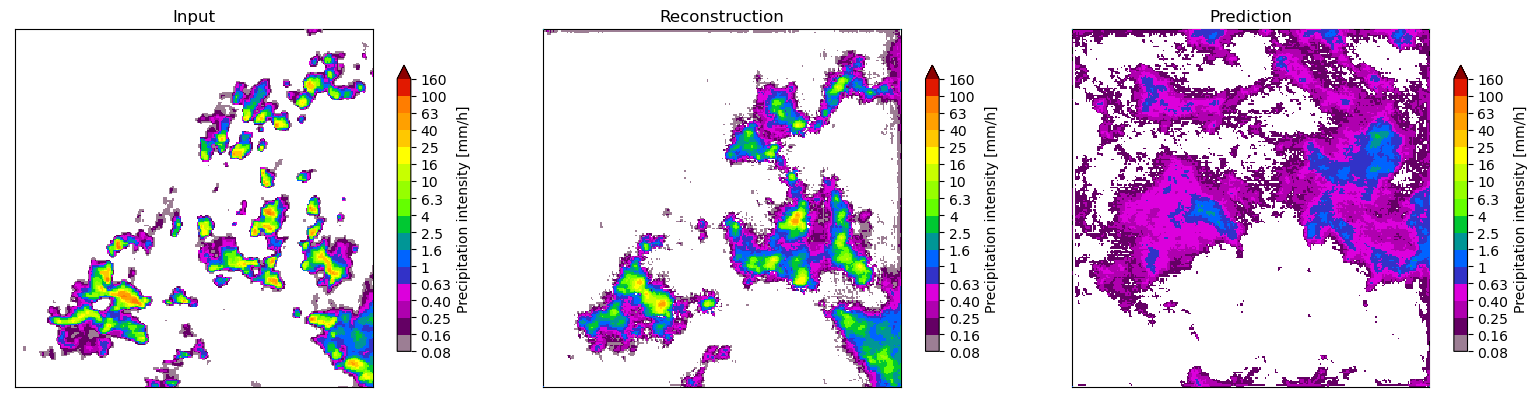

4
1
4
Start Time: 201805291515 Lead Time: 60 mins


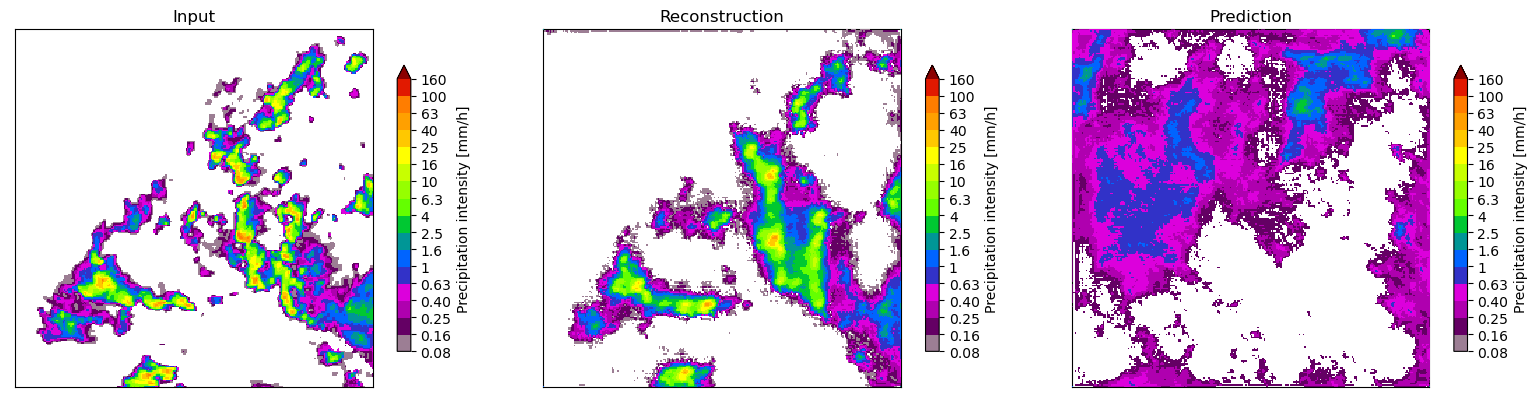

5
2
5
Start Time: 201805291515 Lead Time: 90 mins


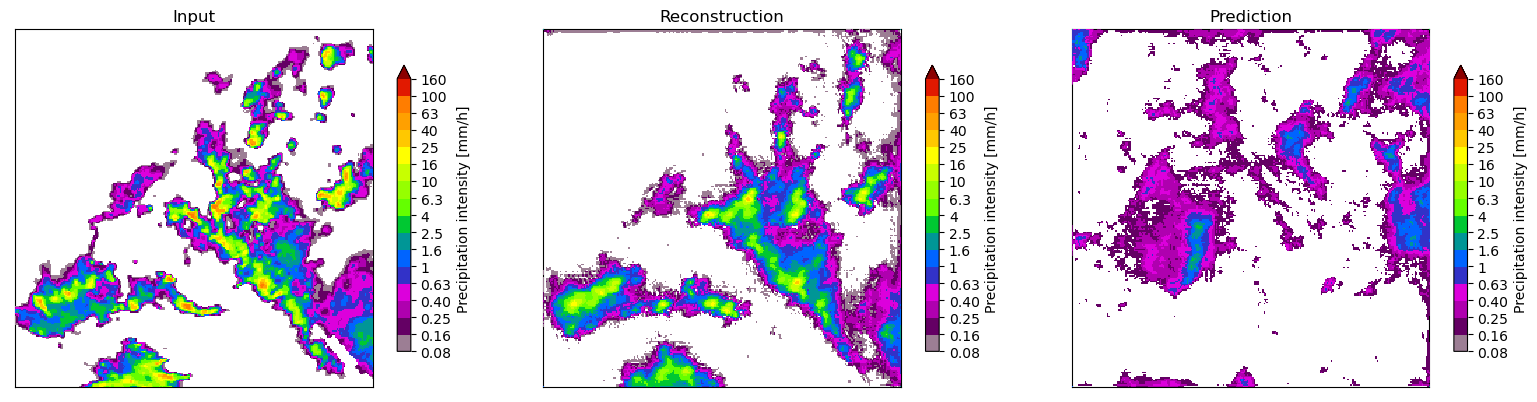

6
3
6
Start Time: 201805291515 Lead Time: 120 mins


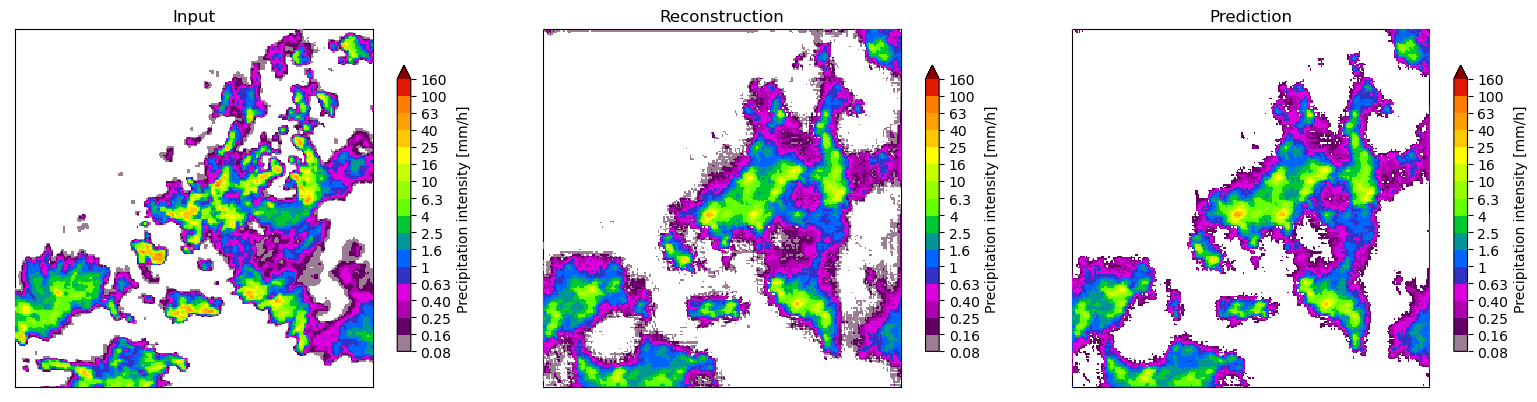

7
4
7
Start Time: 201805291515 Lead Time: 150 mins


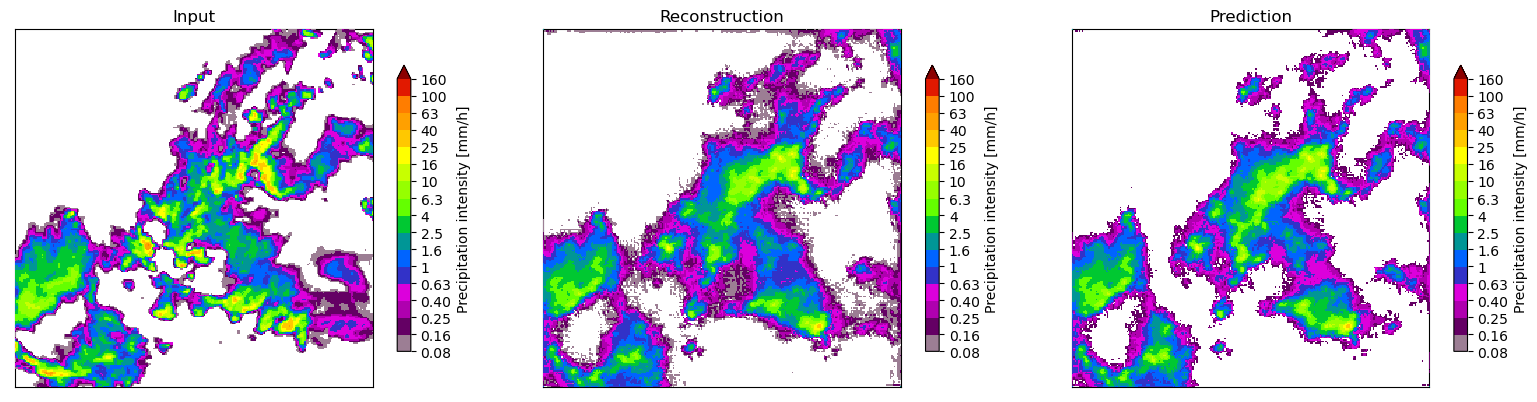

8
5
8
Start Time: 201805291515 Lead Time: 180 mins


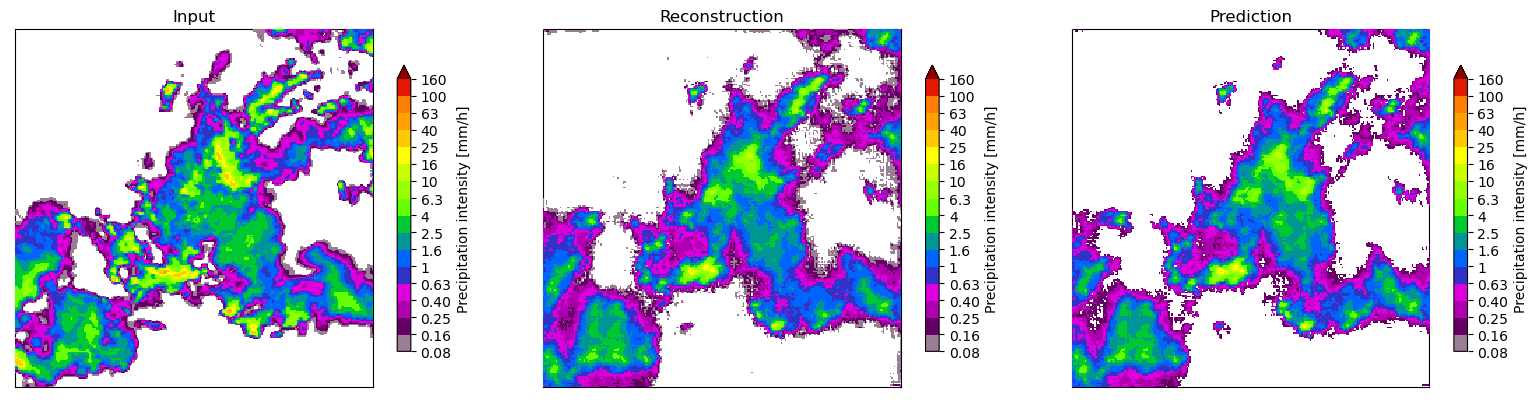

201805291520


In [13]:
import time
import matplotlib.pyplot as plt 

from pysteps.verification.detcatscores import det_cat_fct
from pysteps.verification.detcontscores import det_cont_fct
from pysteps.verification.spatialscores import intensity_scale
from pysteps.visualization import plot_precip_field
threshold = 0.16
pcc_average = 0
tokenizer=tokenizer.to(device)
j = 0
for i, (images,time) in enumerate(loaders['test']):
    print(time[0])
    if i<0:continue
    if i>=1:break

    print("images_size",images.size())

    #image = images[:,:,:,:]
    image = images.unsqueeze(2)
    #image = image.view(9,1,1,256,256)
    
    input_image= image.to(device)  # batch x
    print("input image", input_image.size())
    a_r = tokenizer.encode(input_image,should_preprocess=True).tokens
    a_r1=a_r.view(2304)
    print(a_r.size())
    a_r2=a_r[:,0:3,:]
    print(a_r2.size())
    a_r2=a_r2.view(768) 
    z_q=tokenizer.embedding(a_r1)
    # Rearrange the tensor using Einops
    z_q = rearrange(z_q, '(b h w) e -> b e h w', b=9, e=256, h=16, w=16).contiguous()
    
    # Decode using tokenizer
    reco = tokenizer.decode(z_q,should_postprocess=True)
    print(reco.size())

    obs_tokens=a_r1.view(1,2304).long()
    print(obs_tokens)
    predict= world_model.forward(obs_tokens)
    predicted_obs=predict[1]
    print("Predicted observations", predicted_obs.size())
    predicted_obs=predicted_obs.view(-1,1024)

    predicted_obs = top_k_logits(predicted_obs, 200)
    print("Predictd1", predicted_obs.size())
    #predict_1=predict_1.unsqueeze(1)
    #print("prdict 1", predict_1.size())
    #predicted_tokens=tokenizer.decode(predict_1)
    print("Predictd2", predicted_obs.size())

    tokens = torch.multinomial(torch.softmax(predicted_obs, dim=-1), num_samples=1)
    tokens=tokens.squeeze(-1)
    print("generated", tokens.size())
    
    predicted_tokens= rearrange(tokenizer.embedding(tokens), '(b h w) e -> b e h w', b=6, e=256, h=16, w=16).contiguous()
    print(predicted_tokens.size())
    predict_1=tokenizer.decode(predicted_tokens[:,:,:,:],should_postprocess=True)
    print("Predicted1", predict_1.size())
    #predict_1=predict_1[0:1,:,:,:]
    #print("Predicted1", predict_1.size())

    for t in range(6):
        a_display = images[0,t+3,:,:].to('cpu').detach().numpy()*40
        print(t+3)
        a_r_display = predict_1[t,0,:,:].to('cpu').detach().numpy()*40
        print(t)
        a_r_display[a_r_display < threshold] = 0.0
        a_r1_display = reco[t+j+3,0,:,:].to('cpu').detach().numpy()*40
        print(t+j+3)
        print("Start Time:", time[0], "Lead Time: {} mins".format(-90+(t+j+4)*30))
        plt.figure(figsize=(16, 4))
        plt.subplot(131)
        plot_precip_field(a_display, title="Input")
        plt.subplot(132)
        plot_precip_field(a_r1_display, title="Reconstruction")
        plt.subplot(133)
        plot_precip_field(a_r_display, title="Prediction")
        plt.tight_layout()
        plt.show()
